In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
tb.seed_everything(0)

In [3]:
EXPERIMENT_NAME = '1127-LSTM-FC-win48'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [4]:
WINDOW_SIZE = 48

In [5]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile, window_size, stride):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size
        
        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            self.indexes.append((i, i + window_size))
            i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        sx, tx = self.indexes[idx]
        sy, ty = sx + 18, tx + 18
        x = self.csv.iloc[sx:tx][self.xcols].to_numpy()
        y = self.csv.iloc[sy:ty][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 300, 3

        return x, y

In [6]:
ds_train = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f, window_size=WINDOW_SIZE, stride=5) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [7]:
len(ds_train), len(ds_test)

(11267, 10867)

In [8]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([48, 6]), torch.Size([48, 3]))

In [9]:
x, y = ds_train[0]

In [10]:
x.shape

torch.Size([48, 6])

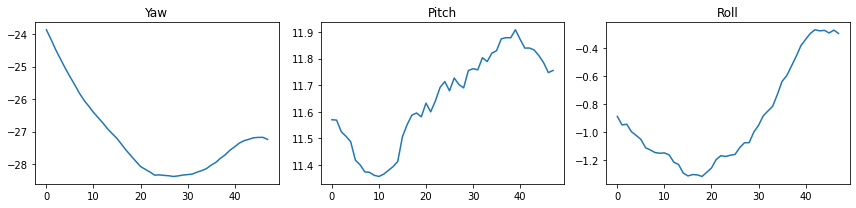

In [11]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(x[:, 0])
plt.title('Yaw')

plt.subplot(1, 3, 2)
plt.plot(x[:, 1])
plt.title('Pitch')

plt.subplot(1, 3, 3)
plt.plot(x[:, 2])
plt.title('Roll')

plt.tight_layout()
plt.show()

# 모델 생성

StackedLSTM Bidirectional

In [12]:
class M2M_LSTM(nn.Module):
    def __init__(self):
        super(M2M_LSTM, self).__init__()

        self.rnn = nn.LSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           batch_first=True,
                           dropout=0.2,
                           bidirectional=True)

        self.out = nn.LSTM(input_size=128, 
                           hidden_size=3, 
                           num_layers=1, 
                           batch_first=True, 
                           dropout=0, 
                           bidirectional=False)
        self.fc = nn.Linear(128, 3)

    def forward(self, x):
        x, (hiddens, cells) = self.rnn(x) # B, S, 128
        #x, (hiddens, cells) = self.out(x) # B, S, 3
        hs = []
        for i in range(x.shape[1]):
            h = self.fc(x[:, i])
            hs.append(h)
        h = torch.stack(hs, 1)

        return h

In [13]:
model = M2M_LSTM().cuda()

In [14]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [15]:
class HPMetric(tb.metrics.InvisibleMetric):
    def __init__(self, name: str):
        super(HPMetric, self).__init__(name)

        self.diff = []

    def on_valid_epoch_end(self, epoch: int, logs: dict):
        # RMS, 99% tile 출력
        yaw_v, pitch_v, roll_v, rms_v, tile99_v = self._calc_values(self.diff)

        print(f'                  validation')
        print(f' - Yaw          : {yaw_v:10f}')
        print(f' - Pitch        : {pitch_v:10f}')
        print(f' - Roll         : {roll_v:10f}')
        print(f' - RMS          : {rms_v:10f}')
        print(f' - 99% Tile     : {tile99_v:10f}')

        self.diff.clear()

    def get_value(self, outputs: torch.Tensor, targets: torch.Tensor, is_train: bool):
        if not is_train:
            self.diff.append((outputs - targets).mean(1).detach().cpu())  # (B, S, 3) --> (B, 3)

    @staticmethod
    def _calc_values(diff):
        diff = torch.cat(diff).abs_()  # (D, 3)
        rms = (diff.square().sum(1) / 3).sqrt()
        tile = rms.flatten().numpy()
        tile99 = np.percentile(tile, 99)
        
        mrms = rms.mean()
        
        # diff = radian2degree(diff)
        #tile = diff.flatten().numpy()
        #tile99 = np.percentile(tile, 99)

        mdiff = diff.mean(dim=0)
        #rms = (mdiff.square().sum() / 3).sqrt()

        return mdiff[0].item(), mdiff[1].item(), mdiff[2].item(), mrms.item(), tile99

In [16]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           HPMetric('hp_metric')]

In [17]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0], patience=3),
             tb.callbacks.SaveCheckpoint({'model': model}, metrics[0], CHECKPOINT_DIR, 'best-ckpt.pth')]

In [18]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [19]:
trainer.fit(ds_train, ds_test, num_epochs=200, batch_size=256, shuffle=True, pin_memory=True)

[0002/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from inf to 236.29599469207054
                  validation
 - Yaw          :  19.286026
 - Pitch        :  10.482852
 - Roll         :   2.533994
 - RMS          :  13.695770
 - 99% Tile     :  28.262603


[0003/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 236.29599469207054 to 193.04975443108137
                  validation
 - Yaw          :  16.864494
 - Pitch        :   9.294923
 - Roll         :   2.531753
 - RMS          :  12.142911
 - 99% Tile     :  26.251199


[0004/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 193.04975443108137 to 153.12663504134775
                  validation
 - Yaw          :  14.154283
 - Pitch        :   8.476082
 - Roll         :   2.424948
 - RMS          :  10.566333
 - 99% Tile     :  23.939721


[0005/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 153.12663504134775 to 125.79630013399346
                  validation
 - Yaw          :  12.252104
 - Pitch        :   7.956457
 - Roll         :   2.327609
 - RMS          :   9.352292
 - 99% Tile     :  22.469343


[0006/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 125.79630013399346 to 107.53736072362855
                  validation
 - Yaw          :  11.145312
 - Pitch        :   7.428315
 - Roll         :   2.347307
 - RMS          :   8.572886
 - 99% Tile     :  21.349171


[0007/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 107.53736072362855 to 90.70161150777064
                  validation
 - Yaw          :   9.770895
 - Pitch        :   6.769597
 - Roll         :   2.310918
 - RMS          :   7.681960
 - 99% Tile     :  20.212653


[0008/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 90.70161150777064 to 80.20603428330533
                  validation
 - Yaw          :   8.947951
 - Pitch        :   6.855727
 - Roll         :   2.256900
 - RMS          :   7.342682
 - 99% Tile     :  19.372895


[0009/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 80.20603428330533 to 67.01780872012294
                  validation
 - Yaw          :   7.426291
 - Pitch        :   6.054201
 - Roll         :   2.328977
 - RMS          :   6.428777
 - 99% Tile     :  18.542337


[0010/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 67.01780872012294 to 57.02597615053487
                  validation
 - Yaw          :   6.894256
 - Pitch        :   5.388184
 - Roll         :   2.305639
 - RMS          :   5.839835
 - 99% Tile     :  17.551035


[0011/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 57.02597615053487 to 48.965486817581706
                  validation
 - Yaw          :   5.696889
 - Pitch        :   5.234534
 - Roll         :   2.330967
 - RMS          :   5.330277
 - 99% Tile     :  16.697451


[0012/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 48.965486817581706 to 42.67712376006814
                  validation
 - Yaw          :   5.552153
 - Pitch        :   4.664537
 - Roll         :   2.335112
 - RMS          :   4.948737
 - 99% Tile     :  15.974994


[0013/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 42.67712376006814 to 36.68631338518719
                  validation
 - Yaw          :   4.561657
 - Pitch        :   4.459445
 - Roll         :   2.321235
 - RMS          :   4.519418
 - 99% Tile     :  15.277945


[0014/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   7.479107
 - Pitch        :   3.337605
 - Roll         :   2.368012
 - RMS          :   5.403148
 - 99% Tile     :  14.692805


[0015/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 36.68631338518719 to 28.535166833289836
                  validation
 - Yaw          :   3.761117
 - Pitch        :   3.809456
 - Roll         :   2.347898
 - RMS          :   3.877269
 - 99% Tile     :  13.919118


[0016/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 28.535166833289836 to 24.205138984114626
                  validation
 - Yaw          :   3.223563
 - Pitch        :   3.492554
 - Roll         :   2.307277
 - RMS          :   3.538978
 - 99% Tile     :  13.365900


[0017/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 24.205138984114626 to 21.621641917284144
                  validation
 - Yaw          :   3.362989
 - Pitch        :   3.045101
 - Roll         :   2.298156
 - RMS          :   3.391119
 - 99% Tile     :  12.701631


[0018/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 21.621641917284144 to 18.78198414070662
                  validation
 - Yaw          :   2.709467
 - Pitch        :   2.784560
 - Roll         :   2.311839
 - RMS          :   3.071049
 - 99% Tile     :  12.193050


[0019/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 18.78198414070662 to 17.539858086164607
                  validation
 - Yaw          :   2.946572
 - Pitch        :   2.401314
 - Roll         :   2.316096
 - RMS          :   3.058942
 - 99% Tile     :  11.683297


[0020/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 17.539858086164607 to 15.460298272066337
                  validation
 - Yaw          :   2.261628
 - Pitch        :   2.588757
 - Roll         :   2.248848
 - RMS          :   2.788902
 - 99% Tile     :  11.306907


[0021/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 15.460298272066337 to 13.80896971392077
                  validation
 - Yaw          :   1.929645
 - Pitch        :   2.292183
 - Roll         :   2.277326
 - RMS          :   2.574721
 - 99% Tile     :  10.806915


[0022/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 13.80896971392077 to 12.804284088833384
                  validation
 - Yaw          :   2.218327
 - Pitch        :   1.947723
 - Roll         :   2.254774
 - RMS          :   2.526402
 - 99% Tile     :  10.420835


[0023/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.244944
 - Pitch        :   2.420095
 - Roll         :   2.254558
 - RMS          :   2.680655
 - 99% Tile     :  10.166665


[0024/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 12.804284088833384 to 11.390624744947566
                  validation
 - Yaw          :   2.032191
 - Pitch        :   1.759062
 - Roll         :   2.269234
 - RMS          :   2.412446
 - 99% Tile     :   9.858494


[0025/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 11.390624744947566 to 10.832576798838241
                  validation
 - Yaw          :   1.826668
 - Pitch        :   1.968393
 - Roll         :   2.275218
 - RMS          :   2.354291
 - 99% Tile     :   9.621049


[0026/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 10.832576798838241 to 10.081992343414663
                  validation
 - Yaw          :   1.693180
 - Pitch        :   1.813743
 - Roll         :   2.215575
 - RMS          :   2.260662
 - 99% Tile     :   9.247409


[0027/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 10.081992343414663 to 9.386356789012288
                  validation
 - Yaw          :   1.539063
 - Pitch        :   1.692765
 - Roll         :   2.215503
 - RMS          :   2.148699
 - 99% Tile     :   8.894453


[0028/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   2.976531
 - Pitch        :   1.418044
 - Roll         :   2.191125
 - RMS          :   2.735181
 - 99% Tile     :   8.963810


[0029/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 9.386356789012288 to 8.527769241222115
                  validation
 - Yaw          :   1.366929
 - Pitch        :   1.268906
 - Roll         :   2.213855
 - RMS          :   1.987393
 - 99% Tile     :   8.375863


[0030/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.527769241222115 to 8.392807530802349
                  validation
 - Yaw          :   1.654665
 - Pitch        :   1.281589
 - Roll         :   2.191166
 - RMS          :   2.055547
 - 99% Tile     :   8.077012


[0031/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.392807530802349 to 8.206110117047333
                  validation
 - Yaw          :   1.494579
 - Pitch        :   1.287383
 - Roll         :   2.178261
 - RMS          :   2.014854
 - 99% Tile     :   7.973408


[0032/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.206110117047333 to 8.178203130877295
                  validation
 - Yaw          :   1.555979
 - Pitch        :   1.294243
 - Roll         :   2.209146
 - RMS          :   2.040134
 - 99% Tile     :   7.718905


[0033/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 8.178203130877295 to 7.998656332492829
                  validation
 - Yaw          :   1.359066
 - Pitch        :   1.433862
 - Roll         :   2.179157
 - RMS          :   1.993858
 - 99% Tile     :   7.602064


[0034/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.998656332492829 to 7.644460879092993
                  validation
 - Yaw          :   1.211520
 - Pitch        :   1.374613
 - Roll         :   2.161777
 - RMS          :   1.921881
 - 99% Tile     :   7.632260


[0035/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   3.281046
 - Pitch        :   1.116425
 - Roll         :   2.351586
 - RMS          :   2.825332
 - 99% Tile     :   9.262995


[0036/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.644460879092993 to 7.503813105960225
                  validation
 - Yaw          :   1.441166
 - Pitch        :   1.268260
 - Roll         :   2.202629
 - RMS          :   1.979774
 - 99% Tile     :   7.265452


[0037/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.503813105960225 to 7.332473247550254
                  validation
 - Yaw          :   1.177081
 - Pitch        :   1.522717
 - Roll         :   2.160764
 - RMS          :   1.934244
 - 99% Tile     :   7.249315


[0038/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 7.332473247550254 to 6.654629509116328
                  validation
 - Yaw          :   1.060171
 - Pitch        :   1.121387
 - Roll         :   2.193003
 - RMS          :   1.778472
 - 99% Tile     :   7.000755


[0039/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.934958
 - Pitch        :   1.085124
 - Roll         :   2.176430
 - RMS          :   2.090995
 - 99% Tile     :   6.955108


[0040/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.336223
 - Pitch        :   1.110216
 - Roll         :   2.171183
 - RMS          :   1.853039
 - 99% Tile     :   6.857332


[0041/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.071840
 - Pitch        :   1.700308
 - Roll         :   2.170541
 - RMS          :   1.929646
 - 99% Tile     :   6.729295


[0042/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.654629509116328 to 6.337114023607829
                  validation
 - Yaw          :   1.048499
 - Pitch        :   1.105351
 - Roll         :   2.170228
 - RMS          :   1.763402
 - 99% Tile     :   6.679975


[0043/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.111717
 - Pitch        :   1.054933
 - Roll         :   2.198395
 - RMS          :   1.797689
 - 99% Tile     :   6.653029


[0044/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.313683
 - Pitch        :   1.078858
 - Roll         :   2.142503
 - RMS          :   1.823945
 - 99% Tile     :   6.621555


[0045/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.323319
 - Pitch        :   1.037324
 - Roll         :   2.161428
 - RMS          :   1.823942
 - 99% Tile     :   6.650980


[0046/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 6.337114023607829 to 5.964391392330792
                  validation
 - Yaw          :   0.838311
 - Pitch        :   1.008209
 - Roll         :   2.169467
 - RMS          :   1.666069
 - 99% Tile     :   6.664193


[0047/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.177993
 - Pitch        :   1.002503
 - Roll         :   2.170279
 - RMS          :   1.770393
 - 99% Tile     :   6.637906


[0048/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.867317
 - Pitch        :   1.048984
 - Roll         :   2.149417
 - RMS          :   1.680272
 - 99% Tile     :   6.701283


[0049/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.956876
 - Pitch        :   1.026980
 - Roll         :   2.167515
 - RMS          :   1.697984
 - 99% Tile     :   6.710208


[0050/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.959136
 - Pitch        :   1.019053
 - Roll         :   2.157214
 - RMS          :   1.697051
 - 99% Tile     :   6.720226


[0051/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.964391392330792 to 5.88019485529079
                  validation
 - Yaw          :   0.851790
 - Pitch        :   0.988734
 - Roll         :   2.152874
 - RMS          :   1.653900
 - 99% Tile     :   6.668369


[0052/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.908777
 - Pitch        :   0.984846
 - Roll         :   2.167248
 - RMS          :   1.677219
 - 99% Tile     :   6.664835


[0053/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.907015
 - Pitch        :   0.979539
 - Roll         :   2.162212
 - RMS          :   1.671196
 - 99% Tile     :   6.649982


[0054/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.992078
 - Pitch        :   1.010177
 - Roll         :   2.155702
 - RMS          :   1.703433
 - 99% Tile     :   6.608591


[0055/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.88019485529079 to 5.869591554930044
                  validation
 - Yaw          :   0.855185
 - Pitch        :   0.974040
 - Roll         :   2.169497
 - RMS          :   1.657741
 - 99% Tile     :   6.608298


[0056/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.848907
 - Pitch        :   0.995323
 - Roll         :   2.174034
 - RMS          :   1.662483
 - 99% Tile     :   6.600844


[0057/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.910800
 - Pitch        :   0.980051
 - Roll         :   2.168576
 - RMS          :   1.673034
 - 99% Tile     :   6.598694


[0058/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.884334
 - Pitch        :   0.977190
 - Roll         :   2.165233
 - RMS          :   1.664439
 - 99% Tile     :   6.594735


[0059/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.878232
 - Pitch        :   1.000809
 - Roll         :   2.155021
 - RMS          :   1.664251
 - 99% Tile     :   6.598585


[0060/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.879732
 - Pitch        :   0.985708
 - Roll         :   2.161420
 - RMS          :   1.664619
 - 99% Tile     :   6.586959


[0061/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.869591554930044 to 5.8641025340834325
                  validation
 - Yaw          :   0.875576
 - Pitch        :   0.994080
 - Roll         :   2.156942
 - RMS          :   1.662518
 - 99% Tile     :   6.585311


[0062/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.8641025340834325 to 5.86034064098846
                  validation
 - Yaw          :   0.867154
 - Pitch        :   0.990844
 - Roll         :   2.163013
 - RMS          :   1.661623
 - 99% Tile     :   6.590159


[0063/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.86034064098846 to 5.84380290120147
                  validation
 - Yaw          :   0.864776
 - Pitch        :   0.982083
 - Roll         :   2.160567
 - RMS          :   1.657584
 - 99% Tile     :   6.572095


[0064/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.84380290120147 to 5.842558345129325
                  validation
 - Yaw          :   0.868165
 - Pitch        :   0.985352
 - Roll         :   2.158915
 - RMS          :   1.658151
 - 99% Tile     :   6.576445


[0065/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.873052
 - Pitch        :   1.008318
 - Roll         :   2.156375
 - RMS          :   1.665067
 - 99% Tile     :   6.571177


[0066/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.842558345129325 to 5.83422152940617
                  validation
 - Yaw          :   0.859099
 - Pitch        :   0.996534
 - Roll         :   2.152503
 - RMS          :   1.655742
 - 99% Tile     :   6.574791


[0067/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.871897
 - Pitch        :   0.975956
 - Roll         :   2.165581
 - RMS          :   1.658353
 - 99% Tile     :   6.560506


[0068/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.83422152940617 to 5.819152506284935
                  validation
 - Yaw          :   0.852246
 - Pitch        :   0.990535
 - Roll         :   2.153685
 - RMS          :   1.651534
 - 99% Tile     :   6.557329


[0069/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.897440
 - Pitch        :   0.978289
 - Roll         :   2.159248
 - RMS          :   1.662884
 - 99% Tile     :   6.550072


[0070/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.861276
 - Pitch        :   0.998104
 - Roll         :   2.154067
 - RMS          :   1.656572
 - 99% Tile     :   6.540698


[0071/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.887437
 - Pitch        :   1.000252
 - Roll         :   2.147153
 - RMS          :   1.660979
 - 99% Tile     :   6.551110


[0072/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.891825
 - Pitch        :   0.996442
 - Roll         :   2.150040
 - RMS          :   1.662111
 - 99% Tile     :   6.544910


[0073/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.860784
 - Pitch        :   0.994684
 - Roll         :   2.159185
 - RMS          :   1.657667
 - 99% Tile     :   6.542301


[0074/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 1.5625e-05 to 7.8125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.867936
 - Pitch        :   0.991130
 - Roll         :   2.159192
 - RMS          :   1.658824
 - 99% Tile     :   6.505702


[0075/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.879283
 - Pitch        :   0.992600
 - Roll         :   2.158017
 - RMS          :   1.662426
 - 99% Tile     :   6.506293


[0076/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.819152506284935 to 5.817516780176828
                  validation
 - Yaw          :   0.851453
 - Pitch        :   0.985763
 - Roll         :   2.159169
 - RMS          :   1.654288
 - 99% Tile     :   6.507232


[0077/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.868821
 - Pitch        :   0.989025
 - Roll         :   2.157009
 - RMS          :   1.658111
 - 99% Tile     :   6.506554


[0078/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.857657
 - Pitch        :   0.989815
 - Roll         :   2.159232
 - RMS          :   1.656464
 - 99% Tile     :   6.502599


[0079/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 7.8125e-06 to 3.90625e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.882689
 - Pitch        :   0.987554
 - Roll         :   2.157688
 - RMS          :   1.660893
 - 99% Tile     :   6.506253


[0080/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.862913
 - Pitch        :   0.989151
 - Roll         :   2.156781
 - RMS          :   1.655520
 - 99% Tile     :   6.505494


[0081/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.868815
 - Pitch        :   0.987256
 - Roll         :   2.156606
 - RMS          :   1.656917
 - 99% Tile     :   6.504805


[0082/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.817516780176828 to 5.817395587300144
                  validation
 - Yaw          :   0.864289
 - Pitch        :   0.990366
 - Roll         :   2.155519
 - RMS          :   1.655749
 - 99% Tile     :   6.505319


[0083/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.882422
 - Pitch        :   0.988409
 - Roll         :   2.156303
 - RMS          :   1.660013
 - 99% Tile     :   6.509515


[0084/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.866681
 - Pitch        :   0.986841
 - Roll         :   2.156523
 - RMS          :   1.656031
 - 99% Tile     :   6.508329


[0085/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 3.90625e-06 to 1.953125e-06 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.876755
 - Pitch        :   0.986097
 - Roll         :   2.153301
 - RMS          :   1.656667
 - 99% Tile     :   6.509649


[0086/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.817395587300144 to 5.815887349982594
                  validation
 - Yaw          :   0.869307
 - Pitch        :   0.987204
 - Roll         :   2.154008
 - RMS          :   1.655205
 - 99% Tile     :   6.509120


[0087/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.815887349982594 to 5.811678571756494
                  validation
 - Yaw          :   0.867631
 - Pitch        :   0.985348
 - Roll         :   2.153639
 - RMS          :   1.654003
 - 99% Tile     :   6.508851


[0088/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.871230
 - Pitch        :   0.987578
 - Roll         :   2.153629
 - RMS          :   1.655983
 - 99% Tile     :   6.509277


[0089/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.870657
 - Pitch        :   0.988161
 - Roll         :   2.154050
 - RMS          :   1.655886
 - 99% Tile     :   6.508796


[0090/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 1.953125e-06 to 9.765625e-07 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.868948
 - Pitch        :   0.984497
 - Roll         :   2.155513
 - RMS          :   1.655006
 - 99% Tile     :   6.507938


[0091/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.870169
 - Pitch        :   0.985957
 - Roll         :   2.155840
 - RMS          :   1.656374
 - 99% Tile     :   6.507136


[0092/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.873966
 - Pitch        :   0.985073
 - Roll         :   2.154897
 - RMS          :   1.656657
 - 99% Tile     :   6.507998


[0093/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 9.765625e-07 to 4.8828125e-07 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.871501
 - Pitch        :   0.985810
 - Roll         :   2.153971
 - RMS          :   1.655569
 - 99% Tile     :   6.508793


[0094/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.811678571756494 to 5.81164545236632
                  validation
 - Yaw          :   0.867453
 - Pitch        :   0.986130
 - Roll         :   2.153820
 - RMS          :   1.654449
 - 99% Tile     :   6.507970


[0095/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.81164545236632 to 5.810152543145558
                  validation
 - Yaw          :   0.866443
 - Pitch        :   0.985650
 - Roll         :   2.153751
 - RMS          :   1.653982
 - 99% Tile     :   6.507982


[0096/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Save checkpoint: val_loss decreased from 5.810152543145558 to 5.807509232399073
                  validation
 - Yaw          :   0.864200
 - Pitch        :   0.985309
 - Roll         :   2.153400
 - RMS          :   1.653314
 - 99% Tile     :   6.508004


[0097/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.865109
 - Pitch        :   0.986069
 - Roll         :   2.153473
 - RMS          :   1.653848
 - 99% Tile     :   6.507772


[0098/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.868164
 - Pitch        :   0.985783
 - Roll         :   2.153646
 - RMS          :   1.654559
 - 99% Tile     :   6.507657


[0099/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 4.8828125e-07 to 2.44140625e-07 because val_loss did not improved for 3 epochs
val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.870028
 - Pitch        :   0.987325
 - Roll         :   2.153440
 - RMS          :   1.655343
 - 99% Tile     :   6.508554


[0100/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.873830
 - Pitch        :   0.987620
 - Roll         :   2.153427
 - RMS          :   1.656458
 - 99% Tile     :   6.508052


[0101/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   0.873815
 - Pitch        :   0.986851
 - Roll         :   2.153457
 - RMS          :   1.656139
 - 99% Tile     :   6.507682


[0102/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 2.44140625e-07 to 1.220703125e-07 because val_loss did not improved for 3 epochs
val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.872608
 - Pitch        :   0.986794
 - Roll         :   2.153370
 - RMS          :   1.655671
 - 99% Tile     :   6.507870


[0103/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   0.873094
 - Pitch        :   0.986881
 - Roll         :   2.153487
 - RMS          :   1.655943
 - 99% Tile     :   6.507890


[0104/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.873233
 - Pitch        :   0.986931
 - Roll         :   2.153548
 - RMS          :   1.656006
 - 99% Tile     :   6.507923


[0105/0200] Train:   0%|                                                     | 0/45 [00:00<?, ?it/s]

Decaying lr from 1.220703125e-07 to 6.103515625e-08 because val_loss did not improved for 3 epochs
val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   0.872504
 - Pitch        :   0.986808
 - Roll         :   2.153495
 - RMS          :   1.655758
 - 99% Tile     :   6.507785


[0105/0200] Validation: 100%|██████████████████████| 43/43 [00:02<00:00, 17.79it/s, val_loss 5.8146]

val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.872670
 - Pitch        :   0.986508
 - Roll         :   2.153558
 - RMS          :   1.655762
 - 99% Tile     :   6.507806
